<a href="https://www.kaggle.com/code/dataranch/sf-salaries-dataset-xgboost-fastai?scriptVersionId=108591909" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**SF Salary Stats Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

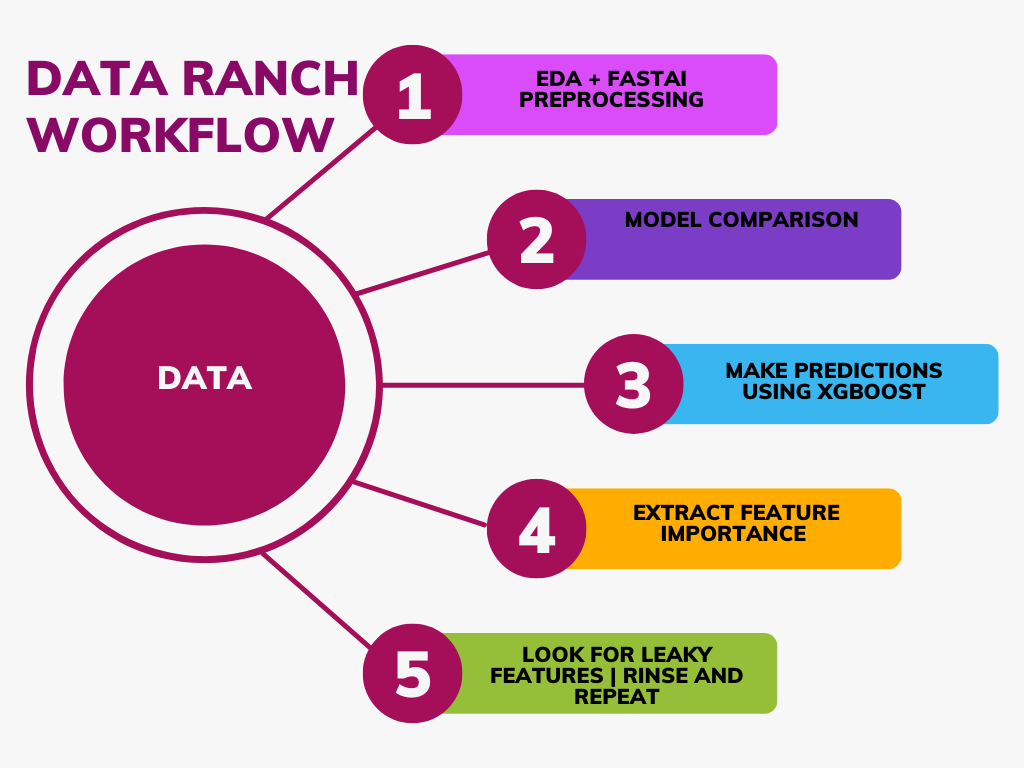

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 570.2 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'sanfrancisco-salary-3-years'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 2000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = False
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
df = pd.read_csv('../input/sanfrancisco-salary-3-years/SanFrancisco_salary (csv).csv', nrows=SAMPLE_COUNT)

param_dir: /kaggle/working/sanfrancisco-salary-3-years


In [12]:
df

Unnamed: 0     Id         EmployeeName                      JobTitle  \
0          36159  36160       Gary Altenberg  Lieutenant, Fire Suppression   
1          36160  36161         Gregory Suhr               Chief of Police   
2          36161  36162           Khoa Trinh   Electronic Maintenance Tech   
3          36162  36163   Joanne Hayes-White        Chief, Fire Department   
4          36163  36164    Frederick Binkley     EMT/Paramedic/Firefighter   
...          ...    ...                  ...                           ...   
1995       38154  38155        Lenin Pabiona              Registered Nurse   
1996       38155  38156  Raquel Nicdao-Icban              Registered Nurse   
1997       38156  38157              Kin Gee                    Manager IV   
1998       38157  38158          Edwin James             Sheriff's Captain   
1999       38158  38159           Linda Kopp              Registered Nurse   

       BasePay  OvertimePay  OtherPay  Benefits  TotalPay  TotalPayBenefits  \
0    128808.87    220909.48  13126.31  44430.12 362844.66         407274.78   
1    302578.00         0.00  18974.11  69810.19 321552.11         391362.30   
2    111921.00    146415.32  78057.41  53102.29 336393.73         389496.02   
3    296943.01         0.00  17816.59  72047.88 314759.60         386807.48   
4    126863.19    192424.49  17917.18  44438.25 337204.86         381643.11   
...        ...          ...       ...       ...       ...               ...   
1995 125337.50      4594.38  23793.78  51511.60 153725.66         205237.26   
1996 132048.26      5899.10  17178.13  50059.06 155125.49         205184.55   
1997 141660.81         0.00   4149.50  59319.59 145810.31         205129.90   
1998 141768.01      2464.05  12191.41  48696.95 156423.47         205120.42   
1999 130290.52     11563.75  10287.50  52977.44 152141.77         205119.21   

      Year Department  Department_ML  
0     2012       Fire              4  
1     2012      Other              2  
2     2012    Not dep              5  
3     2012      Other              2  
4     2012      Other              2  
...    ...        ...            ...  
1995  2012   Medicine              3  
1996  2012   Medicine              3  
1997  2012      Other              2  
1998  2012     Police              1  
1999  2012   Medicine              3  

[2000 rows x 13 columns]

In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
df

Unnamed: 0     Id         EmployeeName                      JobTitle  \
0          36159  36160       Gary Altenberg  Lieutenant, Fire Suppression   
1          36160  36161         Gregory Suhr               Chief of Police   
2          36161  36162           Khoa Trinh   Electronic Maintenance Tech   
3          36162  36163   Joanne Hayes-White        Chief, Fire Department   
4          36163  36164    Frederick Binkley     EMT/Paramedic/Firefighter   
...          ...    ...                  ...                           ...   
1995       38154  38155        Lenin Pabiona              Registered Nurse   
1996       38155  38156  Raquel Nicdao-Icban              Registered Nurse   
1997       38156  38157              Kin Gee                    Manager IV   
1998       38157  38158          Edwin James             Sheriff's Captain   
1999       38158  38159           Linda Kopp              Registered Nurse   

       BasePay  OvertimePay  OtherPay  Benefits  TotalPay  TotalPayBenefits  \
0    128808.87    220909.48  13126.31  44430.12 362844.66         407274.78   
1    302578.00         0.00  18974.11  69810.19 321552.11         391362.30   
2    111921.00    146415.32  78057.41  53102.29 336393.73         389496.02   
3    296943.01         0.00  17816.59  72047.88 314759.60         386807.48   
4    126863.19    192424.49  17917.18  44438.25 337204.86         381643.11   
...        ...          ...       ...       ...       ...               ...   
1995 125337.50      4594.38  23793.78  51511.60 153725.66         205237.26   
1996 132048.26      5899.10  17178.13  50059.06 155125.49         205184.55   
1997 141660.81         0.00   4149.50  59319.59 145810.31         205129.90   
1998 141768.01      2464.05  12191.41  48696.95 156423.47         205120.42   
1999 130290.52     11563.75  10287.50  52977.44 152141.77         205119.21   

      Year Department  Department_ML  
0     2012       Fire              4  
1     2012      Other              2  
2     2012    Not dep              5  
3     2012      Other              2  
4     2012      Other              2  
...    ...        ...            ...  
1995  2012   Medicine              3  
1996  2012   Medicine              3  
1997  2012      Other              2  
1998  2012     Police              1  
1999  2012   Medicine              3  

[2000 rows x 13 columns]

In [15]:
df.isna().sum()

Unnamed: 0          0
Id                  0
EmployeeName        0
JobTitle            0
BasePay             0
OvertimePay         0
OtherPay            0
Benefits            0
TotalPay            0
TotalPayBenefits    0
Year                0
Department          0
Department_ML       0
dtype: int64

In [16]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

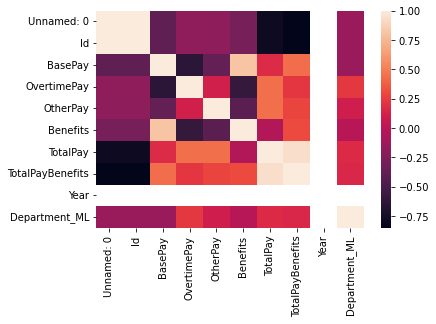

In [17]:
sns.heatmap(df.corr())

In [18]:
df.head().style.background_gradient(cmap = "inferno")

In [19]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [20]:
df.columns

Index(['Unnamed: 0', 'Id', 'EmployeeName', 'JobTitle', 'BasePay',
       'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits',
       'Year', 'Department', 'Department_ML'],
      dtype='object')

In [21]:
#Remove features that we don't want to train or predict on.
del(df['Unnamed: 0'])
del(df['Id'])
del(df['EmployeeName'])

Target Variable: Department_ML
CATS=====================
['Year', 'Department', 'Department_ML']
CONTS=====================
['JobTitle', 'BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['JobTitle', 'BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
Categorical variables that made the cut : ['Year', 'Department', 'Department_ML', 'JobTitle_na']
Tabular Object size: 2000


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.016333341598510742}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03879880905151367}
{'Model': 'BayesianRidge', 'R-Squared': 0.8860218899635426, 'Adjusted R-Squared': 0.883091861427901, 'RMSE': 0.42495184208214953, 'Time taken': 0.03504371643066406}


 10%|▉         | 4/42 [00:00<00:01, 27.50it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.048810482025146484}
{'Model': 'DummyRegressor', 'R-Squared': -0.002367850098619284, 'Adjusted R-Squared': -0.028135661155139102, 'RMSE': 1.2602089360498918, 'Time taken': 0.03995490074157715}
{'Model': 'ElasticNet', 'R-Squared': 0.5445935656776467, 'Adjusted R-Squared': 0.5328864593968664, 'RMSE': 0.8494319097958815, 'Time taken': 0.030928373336791992}


 17%|█▋        | 7/42 [00:00<00:02, 15.68it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.8858743348758471, 'Adjusted R-Squared': 0.8829405131502904, 'RMSE': 0.4252268226265598, 'Time taken': 0.19083857536315918}


 21%|██▏       | 9/42 [00:00<00:02, 13.22it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02358222007751465}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.17332887649536133}
{'Model': 'GammaRegressor', 'R-Squared': 0.6575850719751017, 'Adjusted R-Squared': 0.6487826316659784, 'RMSE': 0.7365552603772837, 'Time taken': 0.029827356338500977}


 26%|██▌       | 11/42 [00:01<00:04,  7.63it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9268259157672029, 'Adjusted R-Squared': 0.9249448339103186, 'RMSE': 0.34049256923806426, 'Time taken': 0.4652543067932129}


 31%|███       | 13/42 [00:01<00:04,  6.15it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992928216, 'Adjusted R-Squared': 0.9999999992746422, 'RMSE': 3.347291223216719e-05, 'Time taken': 0.30272507667541504}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9999999992928216, 'Adjusted R-Squared': 0.9999999992746422, 'RMSE': 3.347291293703974e-05, 'Time taken': 0.15519165992736816}


 33%|███▎      | 14/42 [00:01<00:04,  6.22it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.8762327523884421, 'Adjusted R-Squared': 0.8730510750719496, 'RMSE': 0.4428247203291186, 'Time taken': 0.15064191818237305}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9470453648915187, 'Adjusted R-Squared': 0.9456840632177788, 'RMSE': 0.2896549671592048, 'Time taken': 0.033042192459106445}


 38%|███▊      | 16/42 [00:01<00:03,  6.93it/s]

{'Model': 'KernelRidge', 'R-Squared': -3.1565115275151836, 'Adjusted R-Squared': -3.2633627235952654, 'RMSE': 2.5662176352380692, 'Time taken': 0.1858234405517578}
{'Model': 'Lars', 'R-Squared': 0.8860193371050262, 'Adjusted R-Squared': 0.8830892429432017, 'RMSE': 0.4249566010479471, 'Time taken': 0.022953033447265625}
{'Model': 'LarsCV', 'R-Squared': 0.8858275770638043, 'Adjusted R-Squared': 0.8828925533379381, 'RMSE': 0.425313922402659, 'Time taken': 0.041051387786865234}
{'Model': 'Lasso', 'R-Squared': 0.2447733127154469, 'Adjusted R-Squared': 0.22535874491892882, 'RMSE': 1.0938748935168334, 'Time taken': 0.021877050399780273}


 55%|█████▍    | 23/42 [00:02<00:01, 11.93it/s]

{'Model': 'LassoCV', 'R-Squared': 0.885797472370104, 'Adjusted R-Squared': 0.8828616747446568, 'RMSE': 0.42536999155278515, 'Time taken': 0.1912391185760498}
{'Model': 'LassoLars', 'R-Squared': -0.002367850098619284, 'Adjusted R-Squared': -0.028135661155139102, 'RMSE': 1.2602089360498918, 'Time taken': 0.021781444549560547}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8858275770638043, 'Adjusted R-Squared': 0.8828925533379381, 'RMSE': 0.425313922402659, 'Time taken': 0.04234886169433594}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8856994413385697, 'Adjusted R-Squared': 0.882761123635191, 'RMSE': 0.42555252041223257, 'Time taken': 0.04538917541503906}
{'Model': 'LinearRegression', 'R-Squared': 0.8859072068360098, 'Adjusted R-Squared': 0.8829742301479895, 'RMSE': 0.4251655785328782, 'Time taken': 0.025527477264404297}


 60%|█████▉    | 25/42 [00:02<00:01, 12.92it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.8762327416173576, 'Adjusted R-Squared': 0.8730510640239735, 'RMSE': 0.44282473959795765, 'Time taken': 0.08437347412109375}
{'Model': 'MLPRegressor', 'R-Squared': 0.9512559170245996, 'Adjusted R-Squared': 0.9500028557655918, 'RMSE': 0.27790089324100775, 'Time taken': 2.8409299850463867}


 74%|███████▍  | 31/42 [00:05<00:03,  3.43it/s]

{'Model': 'NuSVR', 'R-Squared': 0.8964732315400641, 'Adjusted R-Squared': 0.8938118750243845, 'RMSE': 0.40500027626991925, 'Time taken': 0.4605283737182617}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8811226322229281, 'Adjusted R-Squared': 0.8780666587582219, 'RMSE': 0.4339888588106822, 'Time taken': 0.016485929489135742}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8859928548071392, 'Adjusted R-Squared': 0.8830620798664487, 'RMSE': 0.4250059654462969, 'Time taken': 0.03525733947753906}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.9493406285671626, 'Adjusted R-Squared': -2.025159153723131, 'RMSE': 2.1616802627553637, 'Time taken': 0.027319908142089844}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7947200013620701, 'Adjusted R-Squared': 0.7894428805744627, 'RMSE': 0.5702986041031226, 'Time taken': 0.028875350952148438}


 76%|███████▌  | 32/42 [00:44<00:53,  5.36s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.14240631137275206, 'Adjusted R-Squared': -0.17177408287333695, 'RMSE': 1.3453624045517267, 'Time taken': 38.50536561012268}
{'Model': 'RANSACRegressor', 'R-Squared': 0.8794942937879429, 'Adjusted R-Squared': 0.8763964607233655, 'RMSE': 0.4369510593644649, 'Time taken': 0.06945538520812988}


 81%|████████  | 34/42 [00:44<00:31,  3.94s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.3458278179168701}
{'Model': 'Ridge', 'R-Squared': 0.8860228177052029, 'Adjusted R-Squared': 0.8830928130189613, 'RMSE': 0.42495011259949, 'Time taken': 0.01784539222717285}
{'Model': 'RidgeCV', 'R-Squared': 0.8860228177052837, 'Adjusted R-Squared': 0.8830928130190442, 'RMSE': 0.4249501125993393, 'Time taken': 0.0261843204498291}
{'Model': 'SGDRegressor', 'R-Squared': 0.8861490967477428, 'Adjusted R-Squared': 0.8832223383093813, 'RMSE': 0.42471463930537534, 'Time taken': 0.02590465545654297}


 90%|█████████ | 38/42 [00:45<00:08,  2.23s/it]

{'Model': 'SVR', 'R-Squared': 0.8953161346242835, 'Adjusted R-Squared': 0.8926250326866044, 'RMSE': 0.40725728870659983, 'Time taken': 0.14621782302856445}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8859072068360098, 'Adjusted R-Squared': 0.8829742301479895, 'RMSE': 0.4251655785328782, 'Time taken': 0.013471841812133789}
{'Model': 'TweedieRegressor', 'R-Squared': 0.6656040334478339, 'Adjusted R-Squared': 0.6570077361071612, 'RMSE': 0.7278795295281275, 'Time taken': 0.019073963165283203}


100%|██████████| 42/42 [00:45<00:00,  1.09s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999993136677, 'Adjusted R-Squared': 0.9999999992960241, 'RMSE': 3.2975866e-05, 'Time taken': 0.5177972316741943}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9999999992928216, 'Adjusted R-Squared': 0.9999999992746422, 'RMSE': 3.347291293703974e-05, 'Time taken': 0.10520267486572266}
Project: sanfrancisco-salary-3-years
sanfrancisco-salary-3-years
Target: Department_ML
Department_ML
Target Standard Deviation: 1.2619175636704643
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
DecisionTreeRegressor                        1.00       1.00  0.00        0.05
RandomForestRegressor                        1.00       1.00  0.00        0.35
BaggingRegressor                             1.00       1.00  0.00        0.04
ExtraTreeRegressor                           1.00    

LEARNING RATE: 0.1


Could not fit model


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       2       2.00
2       4       4.00
3       2       2.00
4       1       1.00
XGBoost RMSE:  3.2975866e-05


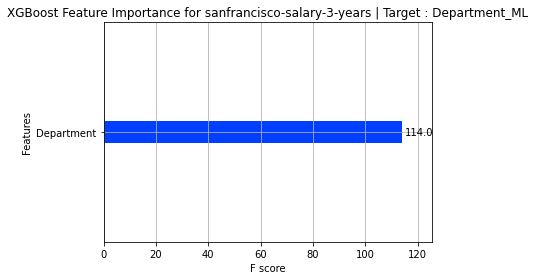

Target Variable: Department
CATS=====================
['JobTitle', 'Year', 'Department', 'Department_ML']
CONTS=====================
['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
10
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
Categorical variables that made the cut : ['JobTitle', 'Year', 'Department', 'Department_ML']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:01, 36.71it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.015958547592163086}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0301058292388916}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03289961814880371}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02967524528503418}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.027224063873291016}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04860639572143555}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed 129.53211975097656 but the user-supplied value

 19%|█▉        | 8/42 [00:00<00:01, 31.55it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.028064966201782227}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.16058802604675293}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01640605926513672}


 29%|██▊       | 12/42 [00:01<00:03,  9.56it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 0.09800453999143334, 'Time taken': 0.46813225746154785}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.11424469947814941}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05720782279968262}


 33%|███▎      | 14/42 [00:01<00:02,  9.73it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 1.2536119880997639e-11, 'Time taken': 0.13452672958374023}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03461194038391113}


 48%|████▊     | 20/42 [00:01<00:01, 14.19it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 0.99998647, 'Time taken': 0.17202425003051758}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.023449182510375977}
LarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03488278388977051}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed 129.53211975097656 but the user-supplied value was 129.5321807861328.
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.023285388946533203}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries


 55%|█████▍    | 23/42 [00:01<00:01, 16.12it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04419708251953125}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.044907569885253906}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 8.834724252476053e-13, 'Time taken': 0.05214881896972656}


 67%|██████▋   | 28/42 [00:02<00:01,  8.39it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 0.050347365, 'Time taken': 0.7917704582214355}
{'Model': 'NuSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 4.440892098500626e-16, 'Time taken': 0.1043543815612793}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02347707748413086}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 0.029592571447373747, 'Time taken': 0.026866674423217773}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.031137943267822266}


 76%|███████▌  | 32/42 [00:32<00:30,  3.02s/it]

{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 8.348877145181177e-14, 'Time taken': 29.831340551376343}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.044188499450683594}


 93%|█████████▎| 39/42 [00:33<00:04,  1.35s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.24254798889160156}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012612104415893555}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02744126319885254}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 0.000150264386893415, 'Time taken': 0.02876138687133789}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.025101423263549805}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02683424949645996}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05038642883300781}


100%|██████████| 42/42 [00:33<00:00,  1.25it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 5.9604645e-08, 'Time taken': 0.48540830612182617}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04016566276550293}
Project: sanfrancisco-salary-3-years
sanfrancisco-salary-3-years
Target: Department
Department
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
Lars                                         1.00       1.00  0.00        0.02
TweedieRegressor                             1.00       1.00  0.00        0.05
TransformedTargetRegressor                   1.00       1.00  0.00        0.03
SVR                                          1.00       1.00  0.00        0.03
RidgeCV                                      1.00     

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.4499266147613525.
Better model found at epoch 1 with _rmse value: 1.8624907732009888.
Better model found at epoch 2 with _rmse value: 0.5137822031974792.
Better model found at epoch 3 with _rmse value: 0.2677159011363983.
Better model found at epoch 4 with _rmse value: 0.11280081421136856.
Better model found at epoch 5 with _rmse value: 0.08675944060087204.
Better model found at epoch 6 with _rmse value: 0.08669746667146683.
No improvement since epoch 6: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: Year
CATS=====================
['JobTitle', 'Year', 'Department', 'Department_ML']
CONTS=====================
['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
10
Looping through continuous variables to find breakpoint


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 310, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Continuous variables that made the cut : ['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
Categorical variables that made the cut : ['JobTitle', 'Year', 'Department', 'Department_ML']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:01, 34.13it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.015033483505249023}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.027660131454467773}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03091597557067871}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04325532913208008}
{'Model': 'DummyRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04328489303588867}
{'Model': 'ElasticNet', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.030138492584228516}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed 125.81674194335938 but the user-supplied val

 19%|█▉        | 8/42 [00:00<00:01, 17.63it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05128955841064453}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.13305330276489258}
{'Model': 'GammaRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01645660400390625}


 31%|███       | 13/42 [00:01<00:03,  9.66it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 0.10476463602672174, 'Time taken': 0.4487128257751465}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.07559967041015625}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.07457327842712402}


 40%|████      | 17/42 [00:01<00:02, 11.15it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 3.8576334742570924e-12, 'Time taken': 0.13562297821044922}
{'Model': 'KNeighborsRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.033632755279541016}
{'Model': 'KernelRidge', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 1.0000293, 'Time taken': 0.10335826873779297}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.023718833923339844}
LarsCV model failed to execute
x and y arrays must have at least 2 entries


 48%|████▊     | 20/42 [00:01<00:01, 12.77it/s]

{'Model': 'Lasso', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.04180121421813965}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed 125.81674194335938 but the user-supplied value was 125.81671905517578.
{'Model': 'LassoLars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.024797916412353516}
LassoLarsCV model failed to execute
x and y arrays must have at least 2 entries
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02942371368408203}


 60%|█████▉    | 25/42 [00:01<00:00, 18.99it/s]

{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.022106409072875977}
{'Model': 'LinearSVR', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 1.491421464122423e-12, 'Time taken': 0.02129960060119629}


 67%|██████▋   | 28/42 [00:02<00:01,  8.17it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 0.04463789, 'Time taken': 0.7538139820098877}
{'Model': 'NuSVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.10506200790405273}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.020188331604003906}
OrthogonalMatchingPursuitCV model failed to execute
attempt to get argmin of an empty sequence
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 0.027604795539127504, 'Time taken': 0.02477717399597168}
{'Model': 'PoissonRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03220391273498535}


 76%|███████▌  | 32/42 [00:33<00:27,  2.79s/it]

{'Model': 'QuantileRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 1.1901590823981678e-13, 'Time taken': 30.503201246261597}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.05790424346923828}


 93%|█████████▎| 39/42 [00:33<00:03,  1.32s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.22490596771240234}
{'Model': 'Ridge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.017438173294067383}
{'Model': 'RidgeCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.030443906784057617}
{'Model': 'SGDRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 0.0002076028781458562, 'Time taken': 0.026683807373046875}
{'Model': 'SVR', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02280282974243164}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.026561975479125977}
{'Model': 'TweedieRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02509903907775879}


100%|██████████| 42/42 [00:34<00:00,  1.23it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': -0.023076923076922995, 'RMSE': 5.9604645e-08, 'Time taken': 0.4835028648376465}
{'Model': 'LGBMRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.03684568405151367}
Project: sanfrancisco-salary-3-years
sanfrancisco-salary-3-years
Target: Year
Year
Target Standard Deviation: 0.0
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            1.00       1.00  0.00        0.02
Lasso                                        1.00       1.00  0.00        0.04
TweedieRegressor                             1.00       1.00  0.00        0.03
TransformedTargetRegressor                   1.00       1.00  0.00        0.03
SVR                                          1.00       1.00  0.00        0.02
RidgeCV                                      1.00       1.00  0.00 

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 0.9285181164741516.
Better model found at epoch 1 with _rmse value: 0.7012878060340881.
Better model found at epoch 2 with _rmse value: 0.5736292600631714.
Better model found at epoch 3 with _rmse value: 0.22740094363689423.
Better model found at epoch 4 with _rmse value: 0.13341394066810608.
Better model found at epoch 5 with _rmse value: 0.10939203947782516.
No improvement since epoch 5: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  5.9604645e-08
XGBoost failed
Target Variable: TotalPayBenefits
CATS=====================
['JobTitle', 'Year', 'Department', 'Department_ML']
CONTS=====================
['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay']
9
Looping through continuous variables to find breakpoint


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 310, in <module>
    plot_importance(xgb)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/plotting.py", line 75, in plot_importance
    'Booster.get_score() results in empty.  ' +
ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.


Continuous variables that made the cut : ['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay']
Categorical variables that made the cut : ['JobTitle', 'Year', 'Department', 'Department_ML']
Tabular Object size: 2000


  7%|▋         | 3/42 [00:00<00:03, 11.16it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9511345102410926, 'Adjusted R-Squared': 0.9500068450928102, 'RMSE': 6627.931280103045, 'Time taken': 0.18994784355163574}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9903222395017472, 'Adjusted R-Squared': 0.9900989065671721, 'RMSE': 2949.6080103992667, 'Time taken': 0.08265447616577148}
{'Model': 'BayesianRidge', 'R-Squared': -30.780948681004084, 'Adjusted R-Squared': -31.51435518902725, 'RMSE': 169028.64012358195, 'Time taken': 0.0248720645904541}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9852984194776336, 'Adjusted R-Squared': 0.9849591522348098, 'RMSE': 3635.45591376828, 'Time taken': 0.03958415985107422}
{'Model': 'DummyRegressor', 'R-Squared': -0.0001723313211936528, 'Adjusted R-Squared': -0.023253231274759534, 'RMSE': 29985.705, 'Time taken': 0.023569822311401367}


 19%|█▉        | 8/42 [00:00<00:02, 15.97it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.919965252437452, 'Adjusted R-Squared': 0.9181182967244701, 'RMSE': 8482.349, 'Time taken': 0.04041934013366699}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed -818.0257568359375 but the user-supplied value was -818.025634765625.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9873881215417735, 'Adjusted R-Squared': 0.9870970781927375, 'RMSE': 3367.1832886977904, 'Time taken': 0.03185725212097168}


 24%|██▍       | 10/42 [00:01<00:03,  8.03it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9953558308148205, 'Adjusted R-Squared': 0.9952486576797779, 'RMSE': 2043.294119974199, 'Time taken': 0.45786213874816895}
{'Model': 'GammaRegressor', 'R-Squared': 0.7976041032773438, 'Adjusted R-Squared': 0.7929334287375902, 'RMSE': 13488.936827595251, 'Time taken': 0.023922443389892578}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.22677544490628732, 'Adjusted R-Squared': 0.20893180132720168, 'RMSE': 26365.116071704953, 'Time taken': 0.48006772994995117}


 29%|██▊       | 12/42 [00:01<00:06,  4.52it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9938986960714891, 'Adjusted R-Squared': 0.9937578967500619, 'RMSE': 2342.007053066995, 'Time taken': 0.35161280632019043}


 33%|███▎      | 14/42 [00:02<00:06,  4.17it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9802107781848356, 'Adjusted R-Squared': 0.9797541038352549, 'RMSE': 4217.850936303983, 'Time taken': 0.4589838981628418}
{'Model': 'HuberRegressor', 'R-Squared': 0.999999999999948, 'Adjusted R-Squared': 0.9999999999999468, 'RMSE': 0.006832226869905007, 'Time taken': 0.13929152488708496}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9801919265591881, 'Adjusted R-Squared': 0.9797348171720924, 'RMSE': 4219.86, 'Time taken': 0.033745527267456055}


 43%|████▎     | 18/42 [00:02<00:03,  7.60it/s]

{'Model': 'KernelRidge', 'R-Squared': -60.5408208524217, 'Adjusted R-Squared': -61.96099364132374, 'RMSE': 235211.48, 'Time taken': 0.09067082405090332}
{'Model': 'Lars', 'R-Squared': 0.9999999999984058, 'Adjusted R-Squared': 0.9999999999983691, 'RMSE': 0.037856378, 'Time taken': 0.026251554489135742}
{'Model': 'LarsCV', 'R-Squared': 0.9999999999990685, 'Adjusted R-Squared': 0.999999999999047, 'RMSE': 0.028937906, 'Time taken': 0.0782017707824707}
{'Model': 'Lasso', 'R-Squared': 0.999999997698334, 'Adjusted R-Squared': 0.9999999976452186, 'RMSE': 1.4384607, 'Time taken': 0.02682352066040039}


 57%|█████▋    | 24/42 [00:02<00:01, 13.85it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed -818.0257568359375 but the user-supplied value was -818.025634765625.
{'Model': 'LassoLars', 'R-Squared': 0.9999964882624023, 'Adjusted R-Squared': 0.9999964072223039, 'RMSE': 56.187263, 'Time taken': 0.024875640869140625}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999993815, 'Adjusted R-Squared': 0.9999999999993672, 'RMSE': 0.023580294, 'Time taken': 0.05419468879699707}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999999996069, 'Adjusted R-Squared': 0.9999999999995978, 'RMSE': 0.018798765, 'Time taken': 0.03106093406677246}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999996687, 'Adjusted R-Squared': 0.999999999999661, 'RMSE': 0.017258376, 'Time taken': 0.02660226821899414}
{'Model': 'LinearSVR', 'R-Squared': -60.50279404046065, 'Adjusted R-Squared': -61.92208928

 62%|██████▏   | 26/42 [00:05<00:06,  2.43it/s]

{'Model': 'MLPRegressor', 'R-Squared': -60.83483165108311, 'Adjusted R-Squared': -62.26178930456963, 'RMSE': 235772.67, 'Time taken': 2.667501926422119}


 71%|███████▏  | 30/42 [00:06<00:03,  3.93it/s]

{'Model': 'NuSVR', 'R-Squared': -0.019290736482739268, 'Adjusted R-Squared': -0.04281283040157158, 'RMSE': 30270.940023674, 'Time taken': 0.21369194984436035}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9016360028864497, 'Adjusted R-Squared': 0.8993660644915217, 'RMSE': 9403.617448860823, 'Time taken': 0.01754927635192871}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999999063, 'Adjusted R-Squared': 0.9999999999999042, 'RMSE': 0.009178008775770161, 'Time taken': 0.03632402420043945}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999999999991347, 'Adjusted R-Squared': 0.9999999999991147, 'RMSE': 0.027891582391621057, 'Time taken': 0.07783937454223633}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9868055562739909, 'Adjusted R-Squared': 0.986501069111083, 'RMSE': 3444.073503227692, 'Time taken': 0.036679983139038086}


 76%|███████▌  | 32/42 [01:34<02:09, 12.95s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.07270296957837408, 'Adjusted R-Squared': -0.09745765349172109, 'RMSE': 31053.932910250165, 'Time taken': 88.83621215820312}
{'Model': 'RANSACRegressor', 'R-Squared': 0.999999999999704, 'Adjusted R-Squared': 0.9999999999996971, 'RMSE': 0.01631298, 'Time taken': 0.06902170181274414}


 88%|████████▊ | 37/42 [01:35<00:28,  5.75s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9921204343550989, 'Adjusted R-Squared': 0.991938598224832, 'RMSE': 2661.509422035099, 'Time taken': 0.711829662322998}
{'Model': 'Ridge', 'R-Squared': 0.9999997146998951, 'Adjusted R-Squared': 0.9999997081160465, 'RMSE': 16.015032, 'Time taken': 0.01723766326904297}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999971444549, 'Adjusted R-Squared': 0.9999999970785577, 'RMSE': 1.6022171873840976, 'Time taken': 0.05238676071166992}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999999929443522, 'Adjusted R-Squared': 0.9999999927815295, 'RMSE': 2.51851948689224, 'Time taken': 0.08516836166381836}


 93%|█████████▎| 39/42 [01:36<00:12,  4.24s/it]

{'Model': 'SVR', 'R-Squared': -0.06697941417648545, 'Adjusted R-Squared': -0.0916020160420965, 'RMSE': 30970.975822979803, 'Time taken': 0.23491334915161133}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999996687, 'Adjusted R-Squared': 0.999999999999661, 'RMSE': 0.017258376, 'Time taken': 0.013120889663696289}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8080284184014931, 'Adjusted R-Squared': 0.8035983049799891, 'RMSE': 13136.97400149768, 'Time taken': 0.01778388023376465}


100%|██████████| 42/42 [01:36<00:00,  2.31s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9938300065820115, 'Adjusted R-Squared': 0.9936876221185195, 'RMSE': 2355.1536, 'Time taken': 0.7007179260253906}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9816829046583682, 'Adjusted R-Squared': 0.9812602024581767, 'RMSE': 4057.9358009090897, 'Time taken': 0.15476179122924805}
Project: sanfrancisco-salary-3-years
sanfrancisco-salary-3-years
Target: TotalPayBenefits
TotalPayBenefits
Target Standard Deviation: 28691.337890625
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HuberRegressor                               1.00       1.00      0.01   
OrthogonalMatchingPursuitCV                  1.00       1.00      0.01   
RANSACRegressor                              1.00       1.00      0.02   
LinearRegression                             1.00       1.00      0.02   
TransformedTargetRegressor                   1.00       1.00      0.02   
LassoLarsIC  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 236708.75.
Better model found at epoch 1 with _rmse value: 236516.890625.
Better model found at epoch 2 with _rmse value: 234359.125.
Better model found at epoch 3 with _rmse value: 210114.8125.
Better model found at epoch 4 with _rmse value: 146334.140625.
Better model found at epoch 5 with _rmse value: 63725.2734375.
Better model found at epoch 6 with _rmse value: 47413.33984375.
No improvement since epoch 6: early stopping


<Figure size 432x288 with 0 Axes>

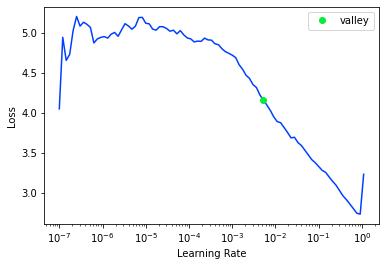

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
     actual  predicted
0 223750.89  223434.52
1 233327.16  232988.55
2 218292.06  217562.70
3 248868.36  248680.67
4 236224.05  235280.31
XGBoost RMSE:  2354.729


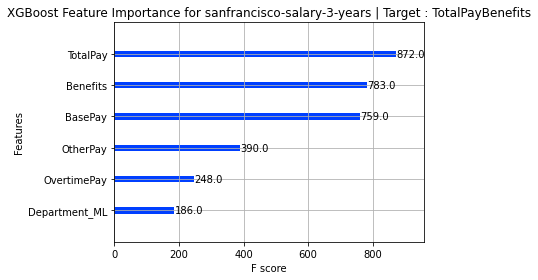

Target Variable: TotalPay
CATS=====================
['JobTitle', 'Year', 'Department', 'Department_ML']
CONTS=====================
['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPayBenefits']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPayBenefits']
Categorical variables that made the cut : ['JobTitle', 'Year', 'Department', 'Department_ML']
Tabular Object size: 2000


  7%|▋         | 3/42 [00:00<00:03, 11.55it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9468244387894902, 'Adjusted R-Squared': 0.9455973104538631, 'RMSE': 6341.644032045281, 'Time taken': 0.1835498809814453}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9894155425983575, 'Adjusted R-Squared': 0.9891712858890889, 'RMSE': 2829.307294569817, 'Time taken': 0.07874822616577148}
{'Model': 'BayesianRidge', 'R-Squared': -11444.029078439295, 'Adjusted R-Squared': -11708.145134095585, 'RMSE': 2942078.5913694436, 'Time taken': 0.02507925033569336}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9881621060602077, 'Adjusted R-Squared': 0.9878889238923664, 'RMSE': 2992.147798586871, 'Time taken': 0.04241204261779785}
{'Model': 'DummyRegressor', 'R-Squared': -0.0010226445790160188, 'Adjusted R-Squared': -0.02412316714622409, 'RMSE': 27514.889, 'Time taken': 0.022513866424560547}


 14%|█▍        | 6/42 [00:00<00:02, 17.65it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.9139789201994812, 'Adjusted R-Squared': 0.9119938183579308, 'RMSE': 8065.815, 'Time taken': 0.04408383369445801}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed -809.32763671875 but the user-supplied value was -809.3275146484375.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9635630956246727, 'Adjusted R-Squared': 0.9627222439852421, 'RMSE': 5249.483270554428, 'Time taken': 0.02810359001159668}


 21%|██▏       | 9/42 [00:00<00:03,  9.36it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9928847859022423, 'Adjusted R-Squared': 0.9927205886538325, 'RMSE': 2319.742642149697, 'Time taken': 0.43880271911621094}
{'Model': 'GammaRegressor', 'R-Squared': 0.7950233320433511, 'Adjusted R-Squared': 0.7902931012443515, 'RMSE': 12450.822279298156, 'Time taken': 0.025414705276489258}


 26%|██▌       | 11/42 [00:01<00:04,  6.73it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.13841454442435452, 'Adjusted R-Squared': -0.16468564929568563, 'RMSE': 29342.427313028926, 'Time taken': 0.455507755279541}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9896823230122016, 'Adjusted R-Squared': 0.9894442227740217, 'RMSE': 2793.423505943192, 'Time taken': 0.34688639640808105}


 33%|███▎      | 14/42 [00:02<00:06,  4.62it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9841068855462786, 'Adjusted R-Squared': 0.9837401213665773, 'RMSE': 3466.971926956143, 'Time taken': 0.4804985523223877}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999535, 'Adjusted R-Squared': 0.9999999999999524, 'RMSE': 0.005931828526948335, 'Time taken': 0.1515812873840332}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.975644203480473, 'Adjusted R-Squared': 0.9750821466377146, 'RMSE': 4291.874, 'Time taken': 0.03736090660095215}


 43%|████▎     | 18/42 [00:02<00:03,  7.36it/s]

{'Model': 'KernelRidge', 'R-Squared': -45.180699107660956, 'Adjusted R-Squared': -46.246407548606975, 'RMSE': 186885.7, 'Time taken': 0.13413476943969727}
{'Model': 'Lars', 'R-Squared': 0.9999999999993576, 'Adjusted R-Squared': 0.9999999999993427, 'RMSE': 0.022041775, 'Time taken': 0.0476534366607666}
{'Model': 'LarsCV', 'R-Squared': 0.9999999999986531, 'Adjusted R-Squared': 0.999999999998622, 'RMSE': 0.031916715, 'Time taken': 0.06473326683044434}
{'Model': 'Lasso', 'R-Squared': 0.9999999827280626, 'Adjusted R-Squared': 0.9999999823294794, 'RMSE': 3.6142347, 'Time taken': 0.050650596618652344}


 55%|█████▍    | 23/42 [00:02<00:01, 11.78it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed -809.32763671875 but the user-supplied value was -809.3275146484375.
{'Model': 'LassoLars', 'R-Squared': 0.9999930675215907, 'Adjusted R-Squared': 0.9999929075413196, 'RMSE': 72.40859, 'Time taken': 0.03574037551879883}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999996804, 'Adjusted R-Squared': 0.999999999999673, 'RMSE': 0.015546679, 'Time taken': 0.05566835403442383}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999999995843, 'Adjusted R-Squared': 0.9999999999995748, 'RMSE': 0.017729385, 'Time taken': 0.03125905990600586}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999997111, 'Adjusted R-Squared': 0.9999999999997045, 'RMSE': 0.0147819435, 'Time taken': 0.025629281997680664}
{'Model': 'LinearSVR', 'R-Squared': -44.96412536867278, 'Adjusted R-Squared': -46.024835954

 62%|██████▏   | 26/42 [00:05<00:06,  2.59it/s]

{'Model': 'MLPRegressor', 'R-Squared': -45.30488654539256, 'Adjusted R-Squared': -46.373460850286236, 'RMSE': 187136.81, 'Time taken': 2.6618618965148926}


 71%|███████▏  | 30/42 [00:05<00:02,  4.07it/s]

{'Model': 'NuSVR', 'R-Squared': -0.00859905405761796, 'Adjusted R-Squared': -0.03187441684356296, 'RMSE': 27618.818614391916, 'Time taken': 0.21168231964111328}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8860026899431762, 'Adjusted R-Squared': 0.8833719827880188, 'RMSE': 9285.239738164651, 'Time taken': 0.01640629768371582}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999998103, 'Adjusted R-Squared': 0.9999999999998059, 'RMSE': 0.011977932027400743, 'Time taken': 0.036898136138916016}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999999999986651, 'Adjusted R-Squared': 0.9999999999986343, 'RMSE': 0.0317740311841623, 'Time taken': 0.07126092910766602}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9768240614076505, 'Adjusted R-Squared': 0.9762892320555194, 'RMSE': 4186.629076432615, 'Time taken': 0.042630910873413086}


 76%|███████▌  | 32/42 [01:43<02:17, 13.71s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.05460320907828242, 'Adjusted R-Squared': -0.07894020621085818, 'RMSE': 28241.669336631763, 'Time taken': 97.22524237632751}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999997401, 'Adjusted R-Squared': 0.9999999999997341, 'RMSE': 0.01401903, 'Time taken': 0.041045188903808594}


 88%|████████▊ | 37/42 [01:44<00:30,  6.18s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9880410665721595, 'Adjusted R-Squared': 0.9877650911853632, 'RMSE': 3007.4058746060527, 'Time taken': 0.7132344245910645}
{'Model': 'Ridge', 'R-Squared': 0.9999995056280445, 'Adjusted R-Squared': 0.9999994942194609, 'RMSE': 19.336271, 'Time taken': 0.013293266296386719}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999950381555, 'Adjusted R-Squared': 0.9999999949236514, 'RMSE': 1.937168489691107, 'Time taken': 0.04023146629333496}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999999873182517, 'Adjusted R-Squared': 0.999999987025596, 'RMSE': 3.0969584889982182, 'Time taken': 0.0956277847290039}


 93%|█████████▎| 39/42 [01:44<00:13,  4.57s/it]

{'Model': 'SVR', 'R-Squared': -0.04814340738307665, 'Adjusted R-Squared': -0.07233133216883991, 'RMSE': 28155.04158378644, 'Time taken': 0.20636391639709473}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999997111, 'Adjusted R-Squared': 0.9999999999997045, 'RMSE': 0.0147819435, 'Time taken': 0.01634693145751953}
{'Model': 'TweedieRegressor', 'R-Squared': 0.803727796884479, 'Adjusted R-Squared': 0.799198438351044, 'RMSE': 12183.588386813357, 'Time taken': 0.028611421585083008}


100%|██████████| 42/42 [01:45<00:00,  2.51s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9895091022137706, 'Adjusted R-Squared': 0.98926700457255, 'RMSE': 2816.775, 'Time taken': 0.6858882904052734}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9841736901735645, 'Adjusted R-Squared': 0.9838084676391082, 'RMSE': 3459.6777724255203, 'Time taken': 0.14243125915527344}
Project: sanfrancisco-salary-3-years
sanfrancisco-salary-3-years
Target: TotalPay
TotalPay
Target Standard Deviation: 27697.74609375
                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
HuberRegressor                               1.00       1.00       0.01   
OrthogonalMatchingPursuitCV                  1.00       1.00       0.01   
RANSACRegressor                              1.00       1.00       0.01   
TransformedTargetRegressor                   1.00       1.00       0.01   
LinearRegression                             1.00       1.00       0.01   
LassoLarsCV               

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 187992.8125.
Better model found at epoch 1 with _rmse value: 187664.546875.
Better model found at epoch 2 with _rmse value: 185163.65625.
Better model found at epoch 3 with _rmse value: 163654.78125.
Better model found at epoch 4 with _rmse value: 73589.6640625.
Better model found at epoch 5 with _rmse value: 67580.5390625.
Better model found at epoch 6 with _rmse value: 36107.60546875.
Better model found at epoch 7 with _rmse value: 35245.33984375.
No improvement since epoch 7: early stopping


<Figure size 432x288 with 0 Axes>

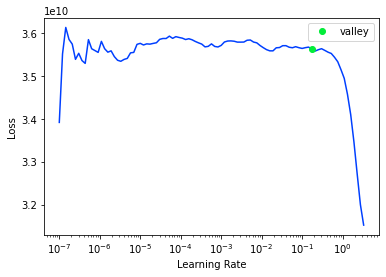

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
     actual  predicted
0 213573.30  214354.70
1 168419.81  168424.23
2 147460.91  148514.59
3 168419.80  168424.23
4 183323.48  183611.50
XGBoost RMSE:  2816.775


Target Variable: Benefits
CATS=====================
['JobTitle', 'Year', 'Department', 'Department_ML']
CONTS=====================
['BasePay', 'OvertimePay', 'OtherPay', 'TotalPay', 'TotalPayBenefits']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['BasePay', 'OvertimePay', 'OtherPay', 'TotalPay', 'TotalPayBenefits']
Categorical variables that made the cut : ['JobTitle', 'Year', 'Department', 'Department_ML']
Tabular Object size: 2000


  7%|▋         | 3/42 [00:00<00:04,  9.12it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7914474481395865, 'Adjusted R-Squared': 0.7866346969428077, 'RMSE': 4418.755004480693, 'Time taken': 0.19160747528076172}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9371522117466757, 'Adjusted R-Squared': 0.935701878171599, 'RMSE': 2425.7004465039063, 'Time taken': 0.08544754981994629}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999995658, 'Adjusted R-Squared': 0.9999999999995558, 'RMSE': 0.006375694669200295, 'Time taken': 0.07479596138000488}


 14%|█▍        | 6/42 [00:00<00:02, 15.31it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9067561660993485, 'Adjusted R-Squared': 0.9046043853170258, 'RMSE': 2954.6240591108053, 'Time taken': 0.04524970054626465}
{'Model': 'DummyRegressor', 'R-Squared': -0.00022632913155207213, 'Adjusted R-Squared': -0.02330847518843404, 'RMSE': 9677.013, 'Time taken': 0.02408003807067871}
{'Model': 'ElasticNet', 'R-Squared': 0.6900687304085619, 'Adjusted R-Squared': 0.6829164703410672, 'RMSE': 5386.7256, 'Time taken': 0.04010963439941406}


 19%|█▉        | 8/42 [00:00<00:02, 13.47it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.22300027564787672, 'Adjusted R-Squared': 0.2050695127782124, 'RMSE': 8529.088, 'Time taken': 0.14657950401306152}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8556165751226837, 'Adjusted R-Squared': 0.8522846499332073, 'RMSE': 3676.637720697911, 'Time taken': 0.028769969940185547}


 24%|██▍       | 10/42 [00:01<00:04,  7.56it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9486037410323545, 'Adjusted R-Squared': 0.9474176735177164, 'RMSE': 2193.6024536451296, 'Time taken': 0.4490032196044922}
{'Model': 'GammaRegressor', 'R-Squared': 0.6172165397005961, 'Adjusted R-Squared': 0.6083830752321484, 'RMSE': 5986.441610357608, 'Time taken': 0.02996373176574707}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.8986374660144236, 'Adjusted R-Squared': 0.8962983306147565, 'RMSE': 3080.5686994222388, 'Time taken': 0.4614901542663574}


 29%|██▊       | 12/42 [00:01<00:06,  4.52it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9113740905260638, 'Adjusted R-Squared': 0.9093288772305114, 'RMSE': 2880.5307871351, 'Time taken': 0.3367805480957031}


 33%|███▎      | 14/42 [00:02<00:06,  4.06it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9586626138038143, 'Adjusted R-Squared': 0.9577086741223639, 'RMSE': 1967.2686673837375, 'Time taken': 0.47782135009765625}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999995479, 'Adjusted R-Squared': 0.9999999999995375, 'RMSE': 0.006506126720685215, 'Time taken': 0.15643763542175293}


 38%|███▊      | 16/42 [00:02<00:04,  5.24it/s]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9273829369278883, 'Adjusted R-Squared': 0.9257071585493011, 'RMSE': 2607.4229, 'Time taken': 0.04241633415222168}
{'Model': 'KernelRidge', 'R-Squared': -24.06472878420881, 'Adjusted R-Squared': -24.643145602305935, 'RMSE': 48442.18, 'Time taken': 0.15052151679992676}


 43%|████▎     | 18/42 [00:02<00:03,  6.99it/s]

{'Model': 'Lars', 'R-Squared': 0.9999999755222165, 'Adjusted R-Squared': 0.9999999749573446, 'RMSE': 1.5138338, 'Time taken': 0.05112957954406738}
{'Model': 'LarsCV', 'R-Squared': 0.999999996651882, 'Adjusted R-Squared': 0.9999999965746177, 'RMSE': 0.5598769, 'Time taken': 0.05322670936584473}
{'Model': 'Lasso', 'R-Squared': 0.9999989168966411, 'Adjusted R-Squared': 0.9999988919019482, 'RMSE': 10.069945, 'Time taken': 0.039353370666503906}


 52%|█████▏    | 22/42 [00:03<00:02,  8.68it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9999324405188117, 'Adjusted R-Squared': 0.9999308814538612, 'RMSE': 79.53079, 'Time taken': 0.2429969310760498}
{'Model': 'LassoLars', 'R-Squared': 0.9985395747676579, 'Adjusted R-Squared': 0.9985058726469115, 'RMSE': 369.77014, 'Time taken': 0.04394412040710449}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999992252, 'Adjusted R-Squared': 0.9999999999992073, 'RMSE': 0.008517394, 'Time taken': 0.06593775749206543}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999999992943, 'Adjusted R-Squared': 0.999999999999278, 'RMSE': 0.0081283795, 'Time taken': 0.037187814712524414}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999989561, 'Adjusted R-Squared': 0.999999999998932, 'RMSE': 0.009886459, 'Time taken': 0.02470874786376953}
{'Model': 'LinearSVR', 'R-Squared': -23.300853946051475, 'Adjusted R-Squared': -23.861642883268047, 'RMSE': 47698.30392306306, 'Time taken': 0.029881715774536133}


 62%|██████▏   | 26/42 [00:06<00:06,  2.58it/s]

{'Model': 'MLPRegressor', 'R-Squared': -23.97945718473652, 'Adjusted R-Squared': -24.55590619669198, 'RMSE': 48359.707, 'Time taken': 2.6344809532165527}


 71%|███████▏  | 30/42 [00:06<00:02,  4.06it/s]

{'Model': 'NuSVR', 'R-Squared': 0.01485384894888564, 'Adjusted R-Squared': -0.007880292998447613, 'RMSE': 9603.78660058932, 'Time taken': 0.2260150909423828}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6357559333803358, 'Adjusted R-Squared': 0.6273503010737281, 'RMSE': 5839.671426367894, 'Time taken': 0.017835140228271484}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999887834, 'Adjusted R-Squared': 0.9999999999885246, 'RMSE': 0.0324057597843488, 'Time taken': 0.03862738609313965}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999999999845877, 'Adjusted R-Squared': 0.999999999984232, 'RMSE': 0.037986219308223663, 'Time taken': 0.11170458793640137}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9869856846202778, 'Adjusted R-Squared': 0.9866853542653612, 'RMSE': 1103.8316244756259, 'Time taken': 0.033969879150390625}


 76%|███████▌  | 32/42 [01:36<02:02, 12.24s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.009487687483589635, 'Adjusted R-Squared': -0.032783557194749235, 'RMSE': 9721.710451297764, 'Time taken': 89.7652952671051}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999990767, 'Adjusted R-Squared': 0.9999999999990554, 'RMSE': 0.009297367, 'Time taken': 0.0543513298034668}


 81%|████████  | 34/42 [01:37<01:11,  8.96s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.944124494707033, 'Adjusted R-Squared': 0.942835059969503, 'RMSE': 2287.1934606515415, 'Time taken': 0.7510478496551514}
{'Model': 'Ridge', 'R-Squared': 0.9997060928857521, 'Adjusted R-Squared': 0.9996993104138848, 'RMSE': 165.88123, 'Time taken': 0.016327857971191406}
{'Model': 'RidgeCV', 'R-Squared': 0.9999968792949835, 'Adjusted R-Squared': 0.9999968072787139, 'RMSE': 17.093009279874096, 'Time taken': 0.026113510131835938}


 88%|████████▊ | 37/42 [01:37<00:28,  5.65s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.9999919492449606, 'Adjusted R-Squared': 0.9999917634583059, 'RMSE': 27.454306329836626, 'Time taken': 0.21686124801635742}


 90%|█████████ | 38/42 [01:37<00:19,  4.83s/it]

{'Model': 'SVR', 'R-Squared': 0.01381744516731842, 'Adjusted R-Squared': -0.008940613790358709, 'RMSE': 9608.837010772344, 'Time taken': 0.20735669136047363}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999989561, 'Adjusted R-Squared': 0.999999999998932, 'RMSE': 0.009886459, 'Time taken': 0.014482975006103516}
{'Model': 'TweedieRegressor', 'R-Squared': 0.6120450223006633, 'Adjusted R-Squared': 0.6030922151229863, 'RMSE': 6026.745234133764, 'Time taken': 0.030609846115112305}


100%|██████████| 42/42 [01:38<00:00,  2.34s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9589797189255516, 'Adjusted R-Squared': 0.9580330970546027, 'RMSE': 1959.7085, 'Time taken': 0.6397144794464111}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9590009672512408, 'Adjusted R-Squared': 0.9580548357262695, 'RMSE': 1959.2009122859931, 'Time taken': 0.13604259490966797}
Project: sanfrancisco-salary-3-years
sanfrancisco-salary-3-years
Target: Benefits
Benefits
Target Standard Deviation: 9782.5986328125
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
BayesianRidge                                1.00       1.00     0.01   
HuberRegressor                               1.00       1.00     0.01   
LassoLarsIC                                  1.00       1.00     0.01   
LassoLarsCV                                  1.00       1.00     0.01   
RANSACRegressor                              1.00       1.00     0.01   
TransformedTargetRegressor          

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 49241.17578125.
Better model found at epoch 1 with _rmse value: 48872.5546875.
Better model found at epoch 2 with _rmse value: 42525.625.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
    actual  predicted
0 38400.09   38274.01
1 43046.97   43334.74
2 40952.27   41594.34
3 53521.81   53403.38
4 58486.10   55697.56
XGBoost RMSE:  1959.429


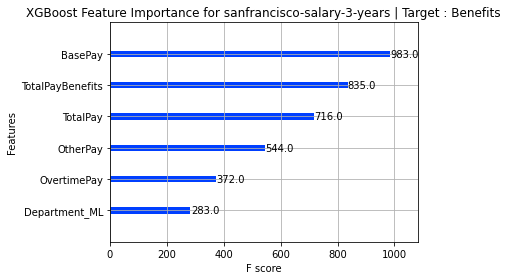

Target Variable: OtherPay
CATS=====================
['JobTitle', 'Year', 'Department', 'Department_ML']
CONTS=====================
['BasePay', 'OvertimePay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['BasePay', 'OvertimePay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
Categorical variables that made the cut : ['JobTitle', 'Year', 'Department', 'Department_ML']
Tabular Object size: 2000


  2%|▏         | 1/42 [00:00<00:06,  6.12it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6492589129696011, 'Adjusted R-Squared': 0.6411648878842843, 'RMSE': 13361.312549231829, 'Time taken': 0.16289639472961426}


  7%|▋         | 3/42 [00:00<00:03, 11.88it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.8889202258423128, 'Adjusted R-Squared': 0.8863568464386739, 'RMSE': 7519.228720110366, 'Time taken': 0.09170961380004883}
{'Model': 'BayesianRidge', 'R-Squared': -31.497048934285566, 'Adjusted R-Squared': -32.246980832769076, 'RMSE': 128610.89590706097, 'Time taken': 0.01985907554626465}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7848756561541708, 'Adjusted R-Squared': 0.779911248219267, 'RMSE': 10464.068662260102, 'Time taken': 0.04185748100280762}
{'Model': 'DummyRegressor', 'R-Squared': -8.952490185198947e-05, 'Adjusted R-Squared': -0.02316851393804842, 'RMSE': 22561.879, 'Time taken': 0.021785736083984375}


 17%|█▋        | 7/42 [00:00<00:01, 20.49it/s]

{'Model': 'ElasticNet', 'R-Squared': 0.5212427032306837, 'Adjusted R-Squared': 0.5101944579206226, 'RMSE': 15610.381, 'Time taken': 0.02398991584777832}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed -789.498779296875 but the user-supplied value was -789.4990234375.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7905762689380439, 'Adjusted R-Squared': 0.785743413605845, 'RMSE': 10324.493321634789, 'Time taken': 0.02657294273376465}


 24%|██▍       | 10/42 [00:00<00:02, 10.70it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9125506101380716, 'Adjusted R-Squared': 0.910532547295104, 'RMSE': 6671.664416249888, 'Time taken': 0.4277172088623047}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.5790228331560036, 'Adjusted R-Squared': 0.5693079754596037, 'RMSE': 14638.112206667585, 'Time taken': 0.4674830436706543}


 29%|██▊       | 12/42 [00:01<00:05,  5.53it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9090356425212799, 'Adjusted R-Squared': 0.9069364650410018, 'RMSE': 6804.424967818345, 'Time taken': 0.3271470069885254}


 33%|███▎      | 14/42 [00:02<00:05,  4.68it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8750944829394192, 'Adjusted R-Squared': 0.8722120479303288, 'RMSE': 7973.456185949558, 'Time taken': 0.44069838523864746}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999477, 'Adjusted R-Squared': 0.9999999999999465, 'RMSE': 0.005161305372176212, 'Time taken': 0.14677119255065918}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8866035427879851, 'Adjusted R-Squared': 0.8839867014677079, 'RMSE': 7597.235, 'Time taken': 0.03389406204223633}


 43%|████▎     | 18/42 [00:02<00:03,  7.11it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.5736475254232926, 'Adjusted R-Squared': 0.5638086221638301, 'RMSE': 14731.2705, 'Time taken': 0.12839651107788086}
{'Model': 'Lars', 'R-Squared': 0.9999999999905442, 'Adjusted R-Squared': 0.9999999999903261, 'RMSE': 0.06937527, 'Time taken': 0.0461430549621582}
{'Model': 'LarsCV', 'R-Squared': 0.9999999999878431, 'Adjusted R-Squared': 0.9999999999875625, 'RMSE': 0.07866264, 'Time taken': 0.06724143028259277}
{'Model': 'Lasso', 'R-Squared': 0.9999998287847527, 'Adjusted R-Squared': 0.9999998248336316, 'RMSE': 9.335273, 'Time taken': 0.04012799263000488}


 55%|█████▍    | 23/42 [00:02<00:01, 11.37it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed -789.498779296875 but the user-supplied value was -789.4990234375.
{'Model': 'LassoLars', 'R-Squared': 0.999910113722447, 'Adjusted R-Squared': 0.9999080394237342, 'RMSE': 213.89592, 'Time taken': 0.035013437271118164}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999905331, 'Adjusted R-Squared': 0.9999999999903146, 'RMSE': 0.06941582, 'Time taken': 0.0559689998626709}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999999905442, 'Adjusted R-Squared': 0.9999999999903261, 'RMSE': 0.06937527, 'Time taken': 0.028344154357910156}
{'Model': 'LinearRegression', 'R-Squared': 0.999999999999652, 'Adjusted R-Squared': 0.999999999999644, 'RMSE': 0.013309056, 'Time taken': 0.025154590606689453}
{'Model': 'LinearSVR', 'R-Squared': -0.3186592404478912, 'Adjusted R-Squared': -0.34908983830438

 62%|██████▏   | 26/42 [00:05<00:05,  2.75it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.32469757192487503, 'Adjusted R-Squared': -0.35526751589237193, 'RMSE': 25966.545, 'Time taken': 2.5241870880126953}


 67%|██████▋   | 28/42 [00:05<00:04,  3.32it/s]

{'Model': 'NuSVR', 'R-Squared': -0.01989495334671898, 'Adjusted R-Squared': -0.04343099073164325, 'RMSE': 22784.186283742034, 'Time taken': 0.2243328094482422}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.08736674417383494, 'Adjusted R-Squared': 0.0663059767316927, 'RMSE': 21552.812285699794, 'Time taken': 0.011815309524536133}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999926864, 'Adjusted R-Squared': 0.9999999999925177, 'RMSE': 0.06101283061796937, 'Time taken': 0.020110607147216797}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999999999959372, 'Adjusted R-Squared': 0.9999999999958435, 'RMSE': 0.0454742444146199, 'Time taken': 0.03661751747131348}
{'Model': 'PoissonRegressor', 'R-Squared': -1.6676078868452548, 'Adjusted R-Squared': -1.729168068849376, 'RMSE': 36848.24411173547, 'Time taken': 0.03215169906616211}


 76%|███████▌  | 32/42 [01:23<01:24,  8.40s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.013778363299870922, 'Adjusted R-Squared': -0.03717324860679083, 'RMSE': 22715.762029439567, 'Time taken': 78.22143244743347}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999993787, 'Adjusted R-Squared': 0.9999999999993644, 'RMSE': 0.017783297, 'Time taken': 0.04994010925292969}


 88%|████████▊ | 37/42 [01:24<00:22,  4.41s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8952733459302786, 'Adjusted R-Squared': 0.8928565769902082, 'RMSE': 7301.034750866091, 'Time taken': 0.8101334571838379}
{'Model': 'Ridge', 'R-Squared': 0.9999812193170323, 'Adjusted R-Squared': 0.9999807859166562, 'RMSE': 97.771324, 'Time taken': 0.014297723770141602}
{'Model': 'RidgeCV', 'R-Squared': 0.9999998104309253, 'Adjusted R-Squared': 0.9999998060562544, 'RMSE': 9.8228960104462, 'Time taken': 0.034502506256103516}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999995095425407, 'Adjusted R-Squared': 0.9999994982242916, 'RMSE': 15.7999776785019, 'Time taken': 0.1122276782989502}


 93%|█████████▎| 39/42 [01:25<00:10,  3.38s/it]

{'Model': 'SVR', 'R-Squared': -0.011424468767291307, 'Adjusted R-Squared': -0.03476503343115178, 'RMSE': 22689.374810894336, 'Time taken': 0.2090001106262207}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.999999999999652, 'Adjusted R-Squared': 0.999999999999644, 'RMSE': 0.013309056, 'Time taken': 0.013758420944213867}
{'Model': 'TweedieRegressor', 'R-Squared': 0.3783802790965807, 'Adjusted R-Squared': 0.36403520861419414, 'RMSE': 17787.634351630484, 'Time taken': 0.028222084045410156}


100%|██████████| 42/42 [01:25<00:00,  2.05s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9366985159324216, 'Adjusted R-Squared': 0.935237712453939, 'RMSE': 5676.266, 'Time taken': 0.6583738327026367}
{'Model': 'LGBMRegressor', 'R-Squared': 0.8656056191552003, 'Adjusted R-Squared': 0.8625042103664742, 'RMSE': 8270.777864980098, 'Time taken': 0.13153433799743652}
Project: sanfrancisco-salary-3-years
sanfrancisco-salary-3-years
Target: OtherPay
OtherPay
Target Standard Deviation: 20093.95703125
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HuberRegressor                               1.00       1.00      0.01   
LinearRegression                             1.00       1.00      0.01   
TransformedTargetRegressor                   1.00       1.00      0.01   
RANSACRegressor                              1.00       1.00      0.02   
PassiveAggressiveRegressor                   1.00       1.00      0.05   
OrthogonalMatchingPursuitCV      

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 26811.470703125.
Better model found at epoch 1 with _rmse value: 26449.48046875.
Better model found at epoch 2 with _rmse value: 20505.98046875.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

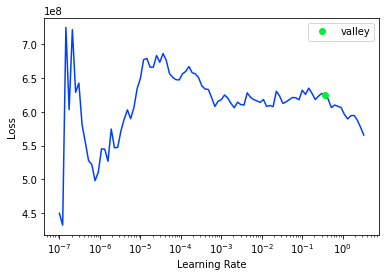

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
    actual  predicted
0  6678.11    6738.83
1  9144.20    8976.64
2 19014.30   17896.71
3 18400.56   15332.87
4 10274.47   13278.21
XGBoost RMSE:  5676.5317


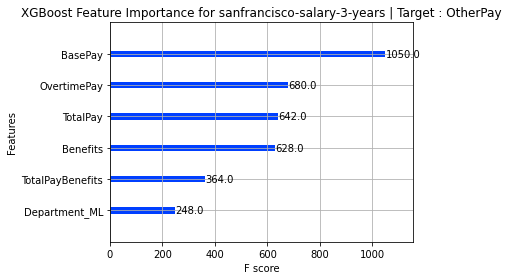

Target Variable: OvertimePay
CATS=====================
['JobTitle', 'Year', 'Department', 'Department_ML']
CONTS=====================
['BasePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['BasePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
Categorical variables that made the cut : ['JobTitle', 'Year', 'Department', 'Department_ML']
Tabular Object size: 2000


 10%|▉         | 4/42 [00:00<00:02, 14.67it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7702826434726032, 'Adjusted R-Squared': 0.7649814737065864, 'RMSE': 14399.436890530968, 'Time taken': 0.17138147354125977}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9708875448336207, 'Adjusted R-Squared': 0.9702157189451658, 'RMSE': 5126.111165530867, 'Time taken': 0.07723808288574219}
{'Model': 'BayesianRidge', 'R-Squared': -108.71521004847139, 'Adjusted R-Squared': -111.24709951112841, 'RMSE': 314689.3339346489, 'Time taken': 0.019324541091918945}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9292585712413235, 'Adjusted R-Squared': 0.9276260767315079, 'RMSE': 7990.712718872475, 'Time taken': 0.03391551971435547}
{'Model': 'DummyRegressor', 'R-Squared': -5.16567702248949e-05, 'Adjusted R-Squared': -0.023129771926460707, 'RMSE': 30044.145, 'Time taken': 0.021007061004638672}
{'Model': 'ElasticNet', 'R-Squared': 0.791501789026688, 'Adjusted R-Squared': 0.7866902918503809, 'RMSE': 13718.283, 'Time taken': 0.023809194564819336}


 17%|█▋        | 7/42 [00:00<00:01, 18.11it/s]

ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed -419.56915283203125 but the user-supplied value was -419.56927490234375.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9379618075242683, 'Adjusted R-Squared': 0.9365301569286745, 'RMSE': 7483.041808727807, 'Time taken': 0.040700674057006836}


 21%|██▏       | 9/42 [00:00<00:03,  9.59it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9804174142132183, 'Adjusted R-Squared': 0.9799655083873695, 'RMSE': 4204.202466220858, 'Time taken': 0.3570108413696289}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 26%|██▌       | 11/42 [00:01<00:04,  7.30it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.987263389230218, 'Adjusted R-Squared': 0.986969467443223, 'RMSE': 3390.592072419007, 'Time taken': 0.3967568874359131}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9725844259545555, 'Adjusted R-Squared': 0.9719517588611991, 'RMSE': 4974.475264527707, 'Time taken': 0.32947683334350586}


 33%|███▎      | 14/42 [00:02<00:05,  4.99it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9633658044443059, 'Adjusted R-Squared': 0.9625203999314822, 'RMSE': 5750.318940710029, 'Time taken': 0.42975640296936035}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999685, 'Adjusted R-Squared': 0.9999999999999677, 'RMSE': 0.005332996424099485, 'Time taken': 0.13096189498901367}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9697549180749313, 'Adjusted R-Squared': 0.9690569546458913, 'RMSE': 5224.876, 'Time taken': 0.032988548278808594}


 43%|████▎     | 18/42 [00:02<00:02,  8.27it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.3732618721901807, 'Adjusted R-Squared': 0.3587986846253388, 'RMSE': 23784.37, 'Time taken': 0.09506869316101074}
{'Model': 'Lars', 'R-Squared': 0.9999999999998378, 'Adjusted R-Squared': 0.999999999999834, 'RMSE': 0.012100513, 'Time taken': 0.024328231811523438}
{'Model': 'LarsCV', 'R-Squared': 0.5968707763689289, 'Adjusted R-Squared': 0.587567794285135, 'RMSE': 19075.271, 'Time taken': 0.07721757888793945}
{'Model': 'Lasso', 'R-Squared': 0.9999999711965966, 'Adjusted R-Squared': 0.9999999705319026, 'RMSE': 5.0988297, 'Time taken': 0.03694725036621094}


 55%|█████▍    | 23/42 [00:02<00:01, 12.35it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed -419.56915283203125 but the user-supplied value was -419.56927490234375.
{'Model': 'LassoLars', 'R-Squared': 0.9999847806962952, 'Adjusted R-Squared': 0.9999844294815943, 'RMSE': 117.20496, 'Time taken': 0.024748563766479492}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999996795, 'Adjusted R-Squared': 0.999999999999672, 'RMSE': 0.017008834, 'Time taken': 0.04804706573486328}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999999999175, 'Adjusted R-Squared': 0.9999999999999156, 'RMSE': 0.008630744, 'Time taken': 0.030295848846435547}
{'Model': 'LinearRegression', 'R-Squared': 0.9999999999996873, 'Adjusted R-Squared': 0.99999999999968, 'RMSE': 0.016801959, 'Time taken': 0.022841453552246094}
{'Model': 'LinearSVR', 'R-Squared': -0.5549786661800655, 'Adjusted R-Squared': -0.59086

 62%|██████▏   | 26/42 [00:05<00:06,  2.59it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.5459080485760155, 'Adjusted R-Squared': -0.5815828496970004, 'RMSE': 37354.285, 'Time taken': 2.6843879222869873}


 74%|███████▍  | 31/42 [00:05<00:02,  4.52it/s]

{'Model': 'NuSVR', 'R-Squared': 0.0006348950567330869, 'Adjusted R-Squared': -0.02242737659580385, 'RMSE': 30033.82834420368, 'Time taken': 0.22770929336547852}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.3749198983625218, 'Adjusted R-Squared': 0.36049497294011856, 'RMSE': 23752.889085420727, 'Time taken': 0.01486968994140625}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.999999999999771, 'Adjusted R-Squared': 0.9999999999997656, 'RMSE': 0.014376542396061792, 'Time taken': 0.038149118423461914}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999999999990242, 'Adjusted R-Squared': 0.9999999999990017, 'RMSE': 0.029677314768366235, 'Time taken': 0.05428194999694824}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7623449129953752, 'Adjusted R-Squared': 0.7568605648337301, 'RMSE': 14646.10560115455, 'Time taken': 0.04407930374145508}


 76%|███████▌  | 32/42 [01:59<02:47, 16.74s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.29659470413200273, 'Adjusted R-Squared': -0.3265161203812026, 'RMSE': 34209.81498856116, 'Time taken': 113.8368124961853}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999996125, 'Adjusted R-Squared': 0.9999999999996035, 'RMSE': 0.018700568, 'Time taken': 0.07277536392211914}


 88%|████████▊ | 37/42 [02:00<00:36,  7.36s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.974161246027979, 'Adjusted R-Squared': 0.9735649670901632, 'RMSE': 4829.3022481089, 'Time taken': 0.7584264278411865}
{'Model': 'Ridge', 'R-Squared': 0.9999973662237351, 'Adjusted R-Squared': 0.9999973054442829, 'RMSE': 48.757122, 'Time taken': 0.012715339660644531}
{'Model': 'RidgeCV', 'R-Squared': 0.999999973537342, 'Adjusted R-Squared': 0.9999999729266653, 'RMSE': 4.887258783721555, 'Time taken': 0.03433823585510254}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999999333982562, 'Adjusted R-Squared': 0.9999999318612929, 'RMSE': 7.753385968370938, 'Time taken': 0.10268378257751465}


 93%|█████████▎| 39/42 [02:00<00:16,  5.41s/it]

{'Model': 'SVR', 'R-Squared': -0.2870072844551472, 'Adjusted R-Squared': -0.3167074525579583, 'RMSE': 34083.10137185601, 'Time taken': 0.21745705604553223}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999996873, 'Adjusted R-Squared': 0.99999999999968, 'RMSE': 0.016801959, 'Time taken': 0.014172554016113281}
{'Model': 'TweedieRegressor', 'R-Squared': 0.6509702509575668, 'Adjusted R-Squared': 0.6429157182873568, 'RMSE': 17749.24263218268, 'Time taken': 0.026546478271484375}


100%|██████████| 42/42 [02:01<00:00,  2.90s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9714423192701735, 'Adjusted R-Squared': 0.970783295868716, 'RMSE': 5077.034, 'Time taken': 0.7210912704467773}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9652968039146549, 'Adjusted R-Squared': 0.96449596092807, 'RMSE': 5596.716917960194, 'Time taken': 0.14116311073303223}
Project: sanfrancisco-salary-3-years
sanfrancisco-salary-3-years
Target: OvertimePay
OvertimePay
Target Standard Deviation: 30083.83203125
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HuberRegressor                               1.00       1.00      0.01   
LassoLarsIC                                  1.00       1.00      0.01   
Lars                                         1.00       1.00      0.01   
OrthogonalMatchingPursuitCV                  1.00       1.00      0.01   
LinearRegression                             1.00       1.00      0.02   
TransformedTargetRegressor   

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 38429.5859375.
Better model found at epoch 1 with _rmse value: 38008.09375.
Better model found at epoch 2 with _rmse value: 29661.958984375.
No improvement since epoch 2: early stopping


<Figure size 432x288 with 0 Axes>

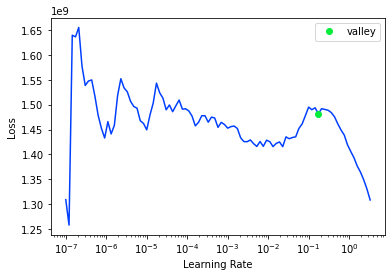

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
    actual  predicted
0     0.00    4743.39
1     0.00    -559.23
2     0.00     -76.72
3 15193.67   22526.68
4 30437.20   29279.64
XGBoost RMSE:  5077.034


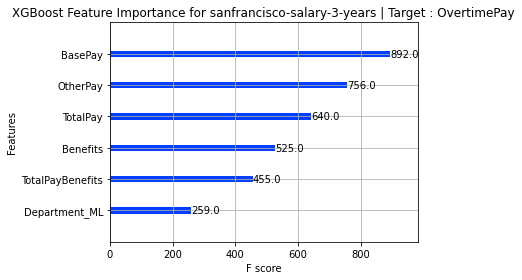

Target Variable: BasePay
CATS=====================
['JobTitle', 'Year', 'Department', 'Department_ML']
CONTS=====================
['OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
9
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']
Categorical variables that made the cut : ['JobTitle', 'Year', 'Department', 'Department_ML']
Tabular Object size: 2000


  7%|▋         | 3/42 [00:00<00:03, 10.13it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8541286013033355, 'Adjusted R-Squared': 0.8507623382564894, 'RMSE': 12226.081529777659, 'Time taken': 0.17982172966003418}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9443941723401813, 'Adjusted R-Squared': 0.943110960932647, 'RMSE': 7548.529708375019, 'Time taken': 0.08056068420410156}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999709, 'Adjusted R-Squared': 0.9999999999999702, 'RMSE': 0.005463698439551262, 'Time taken': 0.05854225158691406}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9393815857246994, 'Adjusted R-Squared': 0.9379826992414233, 'RMSE': 7881.420508600419, 'Time taken': 0.04618334770202637}


 14%|█▍        | 6/42 [00:00<00:02, 16.95it/s]

{'Model': 'DummyRegressor', 'R-Squared': -4.755017888324886e-07, 'Adjusted R-Squared': -0.02307740955183002, 'RMSE': 32011.227, 'Time taken': 0.025878429412841797}
{'Model': 'ElasticNet', 'R-Squared': 0.873997161459646, 'Adjusted R-Squared': 0.8710894036471764, 'RMSE': 11362.983, 'Time taken': 0.027184486389160156}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed 144.93942260742188 but the user-supplied value was 144.9393768310547.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9149559236077983, 'Adjusted R-Squared': 0.9129933679987475, 'RMSE': 9335.213360741149, 'Time taken': 0.02973151206970215}


 21%|██▏       | 9/42 [00:00<00:03,  9.09it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9746659826980026, 'Adjusted R-Squared': 0.974081351529495, 'RMSE': 5095.117986907465, 'Time taken': 0.4513061046600342}
{'Model': 'GammaRegressor', 'R-Squared': 0.7776080690180174, 'Adjusted R-Squared': 0.7724759475338178, 'RMSE': 15095.994426620728, 'Time taken': 0.028524398803710938}


 26%|██▌       | 11/42 [00:01<00:04,  6.48it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.919045321396192, 'Adjusted R-Squared': 0.917177136505335, 'RMSE': 9108.003533205496, 'Time taken': 0.4764699935913086}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9667231799298052, 'Adjusted R-Squared': 0.9659552533128006, 'RMSE': 5839.465852799661, 'Time taken': 0.33489370346069336}


 31%|███       | 13/42 [00:02<00:06,  4.27it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9736028434691991, 'Adjusted R-Squared': 0.9729936783184884, 'RMSE': 5200.927356011455, 'Time taken': 0.4924788475036621}


 38%|███▊      | 16/42 [00:02<00:04,  5.36it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999702, 'Adjusted R-Squared': 0.9999999999999696, 'RMSE': 0.0055246481455575236, 'Time taken': 0.29099011421203613}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9752449035832503, 'Adjusted R-Squared': 0.9746736321274792, 'RMSE': 5036.566, 'Time taken': 0.035042524337768555}
{'Model': 'KernelRidge', 'R-Squared': -20.42769137572156, 'Adjusted R-Squared': -20.922176561315133, 'RMSE': 148180.11, 'Time taken': 0.10721969604492188}
{'Model': 'Lars', 'R-Squared': 0.9999999999422843, 'Adjusted R-Squared': 0.9999999999409523, 'RMSE': 0.2431919, 'Time taken': 0.05209684371948242}


 52%|█████▏    | 22/42 [00:03<00:01, 10.25it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9999999999977531, 'Adjusted R-Squared': 0.9999999999977013, 'RMSE': 0.047983315, 'Time taken': 0.08048248291015625}
{'Model': 'Lasso', 'R-Squared': 0.99999987826573, 'Adjusted R-Squared': 0.9999998754564776, 'RMSE': 11.168855, 'Time taken': 0.025833606719970703}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (4,5) we computed 144.93942260742188 but the user-supplied value was 144.9393768310547.
{'Model': 'LassoLars', 'R-Squared': 0.9999778195358433, 'Adjusted R-Squared': 0.9999773076789782, 'RMSE': 150.76048, 'Time taken': 0.03045344352722168}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999452851, 'Adjusted R-Squared': 0.9999999999440224, 'RMSE': 0.23678546, 'Time taken': 0.09782910346984863}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999999452851, 'Adjusted R-Squared': 0.9999999999440224, 'RMSE': 0.

 62%|██████▏   | 26/42 [00:06<00:05,  2.73it/s]

{'Model': 'MLPRegressor', 'R-Squared': -21.170807006268703, 'Adjusted R-Squared': -21.68244101410567, 'RMSE': 150727.67, 'Time taken': 2.9352760314941406}


 71%|███████▏  | 30/42 [00:06<00:03,  3.97it/s]

{'Model': 'NuSVR', 'R-Squared': 0.0054829678928031145, 'Adjusted R-Squared': -0.017467425155824445, 'RMSE': 31923.340233511874, 'Time taken': 0.2140655517578125}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6815259134878435, 'Adjusted R-Squared': 0.6741765114914091, 'RMSE': 18065.054005868962, 'Time taken': 0.02002263069152832}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999975716, 'Adjusted R-Squared': 0.9999999999975155, 'RMSE': 0.049884470958613425, 'Time taken': 0.0443730354309082}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999999999992243, 'Adjusted R-Squared': 0.9999999999992064, 'RMSE': 0.028194134164508913, 'Time taken': 0.08468937873840332}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9808418214809603, 'Adjusted R-Squared': 0.9803997096689825, 'RMSE': 4430.7711764653595, 'Time taken': 0.046727895736694336}


 76%|███████▌  | 32/42 [01:58<02:26, 14.60s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0012781354421516067, 'Adjusted R-Squared': -0.02438455395235506, 'RMSE': 32031.669905811956, 'Time taken': 111.56904530525208}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999998398, 'Adjusted R-Squared': 0.9999999999998361, 'RMSE': 0.012813453, 'Time taken': 0.04645109176635742}


 88%|████████▊ | 37/42 [01:58<00:34,  6.85s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9588834525230745, 'Adjusted R-Squared': 0.9579346091197608, 'RMSE': 6490.983931421619, 'Time taken': 0.7481913566589355}
{'Model': 'Ridge', 'R-Squared': 0.999996532996257, 'Adjusted R-Squared': 0.9999964529884783, 'RMSE': 59.604546, 'Time taken': 0.017657041549682617}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999649930552, 'Adjusted R-Squared': 0.9999999641852026, 'RMSE': 5.989344840908564, 'Time taken': 0.04032754898071289}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999999110230612, 'Adjusted R-Squared': 0.9999999089697472, 'RMSE': 9.54862733656555, 'Time taken': 0.07646703720092773}


 93%|█████████▎| 39/42 [01:59<00:15,  5.11s/it]

{'Model': 'SVR', 'R-Squared': 0.007442605318594531, 'Adjusted R-Squared': -0.015462565327899469, 'RMSE': 31891.873190988983, 'Time taken': 0.2233121395111084}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999997684, 'Adjusted R-Squared': 0.9999999999997631, 'RMSE': 0.015403707, 'Time taken': 0.012904644012451172}
{'Model': 'TweedieRegressor', 'R-Squared': 0.779219396863898, 'Adjusted R-Squared': 0.7741244598684495, 'RMSE': 15041.206429070584, 'Time taken': 0.028775453567504883}


100%|██████████| 42/42 [02:00<00:00,  2.86s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9808333045173975, 'Adjusted R-Squared': 0.9803909961601066, 'RMSE': 4431.756, 'Time taken': 0.6806399822235107}
{'Model': 'LGBMRegressor', 'R-Squared': 0.975151103931415, 'Adjusted R-Squared': 0.9745776678682938, 'RMSE': 5046.0989653860315, 'Time taken': 0.17313861846923828}
Project: sanfrancisco-salary-3-years
sanfrancisco-salary-3-years
Target: BasePay
BasePay
Target Standard Deviation: 31386.482421875
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
BayesianRidge                                1.00       1.00      0.01   
HuberRegressor                               1.00       1.00      0.01   
RANSACRegressor                              1.00       1.00      0.01   
TransformedTargetRegressor                   1.00       1.00      0.02   
LinearRegression                             1.00       1.00      0.02   
PassiveAggressiveRegressor       

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 151607.03125.
Better model found at epoch 1 with _rmse value: 151153.953125.
Better model found at epoch 2 with _rmse value: 144500.4375.
Better model found at epoch 3 with _rmse value: 64801.34765625.
No improvement since epoch 3: early stopping


<Figure size 432x288 with 0 Axes>

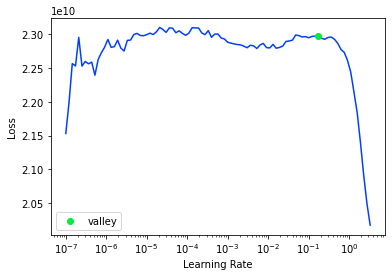

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
     actual  predicted
0 163375.25  162841.98
1 127405.78  124853.36
2 171804.12  169535.31
3 117162.68  115163.84
4 179478.03  179460.89
XGBoost RMSE:  4431.756


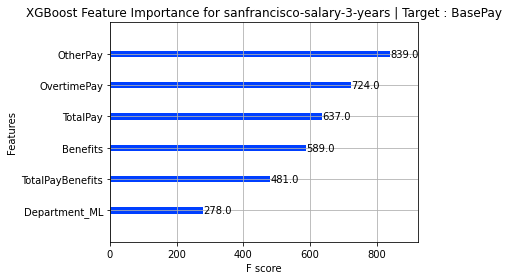

<Figure size 432x288 with 0 Axes>

In [22]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

         feature  importance
0  Department_ML      248.00
1        BasePay     1050.00
2    OvertimePay      680.00
3       Benefits      628.00
4       TotalPay      642.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

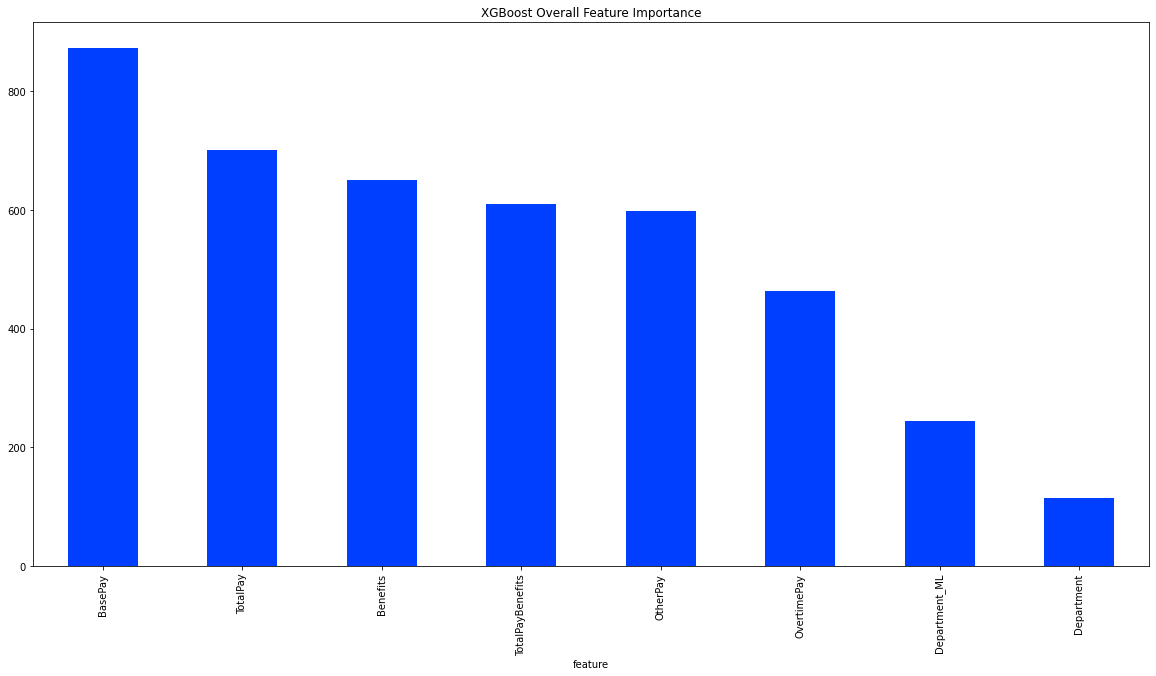

In [23]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [24]:
df.isna().sum()

JobTitle            0
BasePay             0
OvertimePay         0
OtherPay            0
Benefits            0
TotalPay            0
TotalPayBenefits    0
Year                0
Department          0
Department_ML       0
dtype: int64

# **To Be Continued...**